In [ ]:
%pip install numpy pillow matplotlib opencv-python-headless

In [ ]:
%pip install torch torchvision

In [11]:
import torch; print(torch.__version__); print(torch.cuda.is_available())

2.9.1+cpu
False


In [ ]:
%pip install fvcore iopath pycocotools

In [ ]:
%pip install git+https://github.com/facebookresearch/detectron2.git

In [15]:
import contextlib
import datetime
import io
import os
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import math
from itertools import repeat

from fvcore.common.file_io import PathManager
from fvcore.common.timer import Timer

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation,DatasetEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [16]:
class_name_list = ['Right_Index', 'Right_Middle', 'Right_Ring', 'Right_Little', 'Left_Index', 'Left_Middle', 'Left_Ring', 'Left_Little', 'Right_Thumb', 'Left_Thumb']
MetadataCatalog.get('Test').set(thing_classes=class_name_list)

namespace(name='Test',
          thing_classes=['Right_Index',
                         'Right_Middle',
                         'Right_Ring',
                         'Right_Little',
                         'Left_Index',
                         'Left_Middle',
                         'Left_Ring',
                         'Left_Little',
                         'Right_Thumb',
                         'Left_Thumb'])

In [ ]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = os.path.join(dataset_path, 'output')
cfg.OUTPUT_DIR = os.path.join('trained_model')

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# #used faster_rcnn_R_50_FPN_3x as backbone arch
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo

# #used faster_rcnn_R_101_FPN_3x as backbone arch
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml") # Let training initialize from model zoo


cfg.DATASETS.TRAIN = (["Train"])
cfg.DATASETS.TEST = (["Val"])

cfg.MODEL.MASK_ON=False
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #this is far lower than usual.  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_name_list)
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ROI_BOX_HEAD.NUM_CONV=4
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV=8
#cfg.SOLVER.IMS_PER_BATCH = 6 #can be up to  24 for a p100 (6 default)
cfg.SOLVER.IMS_PER_BATCH = 1 #can be up to  24 for a p100 (6 default)
cfg.SOLVER.CHECKPOINT_PERIOD=1500
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA=0.5
cfg.SOLVER.STEPS=[1000,2000,4000, 8000, 12000]
cfg.SOLVER.MAX_ITER=14000


cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True 
cfg.DATALOADER.SAMPLER_TRAIN= "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD=0.01
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#lets just check our output dir exists
cfg.MODEL.BACKBONE.FREEZE_AT=6

In [18]:
# As of 0.3 the XYWHA_ABS box is not supported in the visualizer, this is fixed in master branch atm (19/11/20)
class myVisualizer(Visualizer):
  
    def draw_dataset_dict(self, dic):
        annos = dic.get("annotations", None)
        print("annos before", annos)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None
            print("annos", annos)
            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYWHA_ABS) for x in annos]
            print("draw_dataset_dict boxes\n", boxes)
            labels = [x["category_id"] for x in annos]
            print("labels", labels)
            names = self.metadata.get("thing_classes", None)
            print("names", names)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(labels=labels, boxes=boxes, masks=masks, keypoints=keypts)

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0013499.pth")

cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 #set threshold value to filter our low scordign bboxes

In [33]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)

def calculated_iou(boxA, boxB, overlapThresh):
    """
    boxA, boxB: [x1, y1, x2, y2, ...] (extra fields allowed)
    returns: (overlap_flag, iou)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    interArea = interW * interH

    areaA = max(0.0, boxA[2] - boxA[0]) * max(0.0, boxA[3] - boxA[1])
    areaB = max(0.0, boxB[2] - boxB[0]) * max(0.0, boxB[3] - boxB[1])

    denom = areaA + areaB - interArea
    iou = (interArea / denom) if denom > 0 else 0.0

    overlap_flag = 1 if iou > overlapThresh else 0
    return overlap_flag, iou


In [34]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    
    tag_arr = np.zeros(len(boxes)) # help to find non overlap array
    
    for b_index, box in enumerate(boxes):
        if tag_arr[b_index] == 0:
                for b2_index in range(b_index+1, len(boxes)):
                    if tag_arr[b2_index] == 0:
                        box_overlapped, _ = calculated_iou(boxes[b_index], boxes[b2_index], overlapThresh)
    #                     print(box_overlapped)
                        if box_overlapped> 0:
                             tag_arr[b2_index] = 1
                #print("tag_arr: ", tag_arr)
    
    final_box = []
    #print("tag_arr: ", tag_arr)
    for tag_index, tag_value in enumerate(tag_arr):
        if tag_arr[tag_index] ==0:
            list_box = boxes[tag_index].tolist()
            final_box.append(list_box)
            
            
    return final_box

In [35]:
import glob

image_dir = "test_image"
test_dict = [ {"file_name": p} for p in glob.glob(os.path.join(image_dir, "*.bmp")) ]

In [36]:
#this code use modified non-maximum suppression approache to remove overlapped bboxes
#this code implement majority voteing or most confident label to remove wrong fingerprint labeling
#this code is written for appeding model output results to dataframe
#4 co-ordinate of a bounding box are stored

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

min_iou = 0
not_found_image_label = 555.0
not_found_bbox_angle = 333.0
ZERO = 0
number_of_bboxes_in_dataset = 0
number_of_bboxes_in_result = 0

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6#set threshold value to filter our low scordign bboxes

predictor = DefaultPredictor(cfg)

#insert bb and label to dataframe
# for d in random.sample(test_dict, 1):    
for d in test_dict:
    im = cv2.imread(d["file_name"])
    im_height, im_width, _ = im.shape
    #print(im_width, im_height)
    origin = im_width/2, im_height/2
    outputs = predictor(im)  
    predictions= outputs["instances"].to("cpu")
    
    #############################################################################################
    rlt_bbs = predictions.pred_boxes.tensor.numpy() if predictions.has("pred_boxes") else None
    #print(len(rlt_bbs))

    current_bbs_list = np.zeros((len(rlt_bbs), 5))

    num_of_fingers = 0
    angle_of_detected_fingers = 0



    if len(rlt_bbs) <= 2:
        for box in rlt_bbs:
                num_of_fingers += 1
                #print(box)
                angle_of_detected_fingers += box[4]
        bbox_angle = angle_of_detected_fingers/num_of_fingers
    else:
        for box in rlt_bbs[:2]:
                num_of_fingers += 1
                #print(box)
                angle_of_detected_fingers += box[4]
        bbox_angle = angle_of_detected_fingers/num_of_fingers


    for index, rlt_bb in enumerate(rlt_bbs):
        raw_cx = rlt_bb[0]
        raw_cy = rlt_bb[1]
        raw_w = rlt_bb[2]
        raw_h = rlt_bb[3]
        #bbox_angle = rlt_bb[4]
        #print(raw_cx, raw_cy, w, h, bbox_angle)
        #print('origin', origin)
        rot_cx, rot_cy = rotate(origin, [raw_cx, raw_cy], math.radians(bbox_angle))
    #     print('cx, cy', cx, cy)
        x1 = rot_cx-raw_w/2
        y1 = rot_cy-raw_h/2
        x2 = rot_cx+raw_w/2
        y2 = rot_cy+raw_h/2
        current_bbs_list[index, 0] = x1
        current_bbs_list[index, 1] = y1
        current_bbs_list[index, 2] = x2
        current_bbs_list[index, 3] = y2
        current_bbs_list[index, 4] = index

    #print("current_bbs_list: ",current_bbs_list)
    nms_bbs = non_max_suppression_fast(current_bbs_list, 0.1)
  
    
    
    #############################################################################################
        
    nms_bbs = sorted(nms_bbs)
    #print("nms_bbs", nms_bbs)
    #print("draw_dataset_dict boxes  \n", rlt_bbs)
    
    rlt_cls = predictions.pred_classes.numpy() if predictions.has("pred_classes") else None
#     print("Predicted levels are: ", (rlt_cls))
    
    hand_info = rlt_cls[0] #the hand info of most confident fingerprint is cosidered as slap info. 
                           #If this method not work well, we should consider majority vote method  
    
    if hand_info <=3:
        calculated_labels = [2.0, 3.0, 4.0, 5.0]
    elif (hand_info >3) and (hand_info <=7):
        calculated_labels = [10.0, 9.0, 8.0, 7.0]
    elif (hand_info == 8) or (hand_info == 9):
        calculated_labels = [12.0, 11.0]
    else:
        calculated_labels = not_found_image_label
    

    found_finger_length = min(len(nms_bbs), len(calculated_labels))
    #print("rlt_bbs: ",rlt_bbs)
    for label_index in range(found_finger_length):
        detected_cx = rlt_bbs[int(nms_bbs[label_index][4])][0] #nms_bbs[label_index][0]
        detected_cy = rlt_bbs[int(nms_bbs[label_index][4])][1]
        detected_w = rlt_bbs[int(nms_bbs[label_index][4])][2]
        detected_h = rlt_bbs[int(nms_bbs[label_index][4])][3]
        detected_finger_angle = rlt_bbs[int(nms_bbs[label_index][4])][4]
        detected_class = calculated_labels[label_index]
        
        


Inference time (1 image): 2.1502 seconds


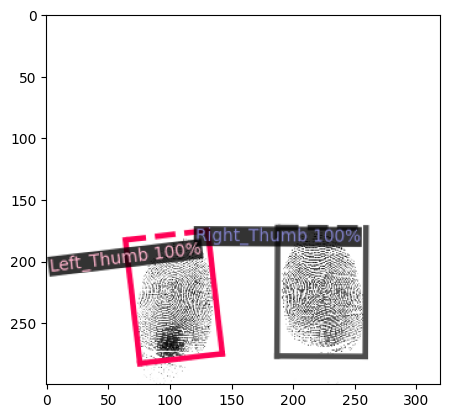

In [43]:
import time

imname = 'test_image/Image_02_1_2.bmp'

im = cv2.imread(imname)

start_time = time.perf_counter()
outputs = predictor(im)  
# print(outputs)
elapsed = time.perf_counter() - start_time
print(f"Inference time (1 image): {elapsed:.4f} seconds")

v = myVisualizer(im[:, :, ::-1],
              metadata=MetadataCatalog.get("Test"), 
              scale=0.2)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

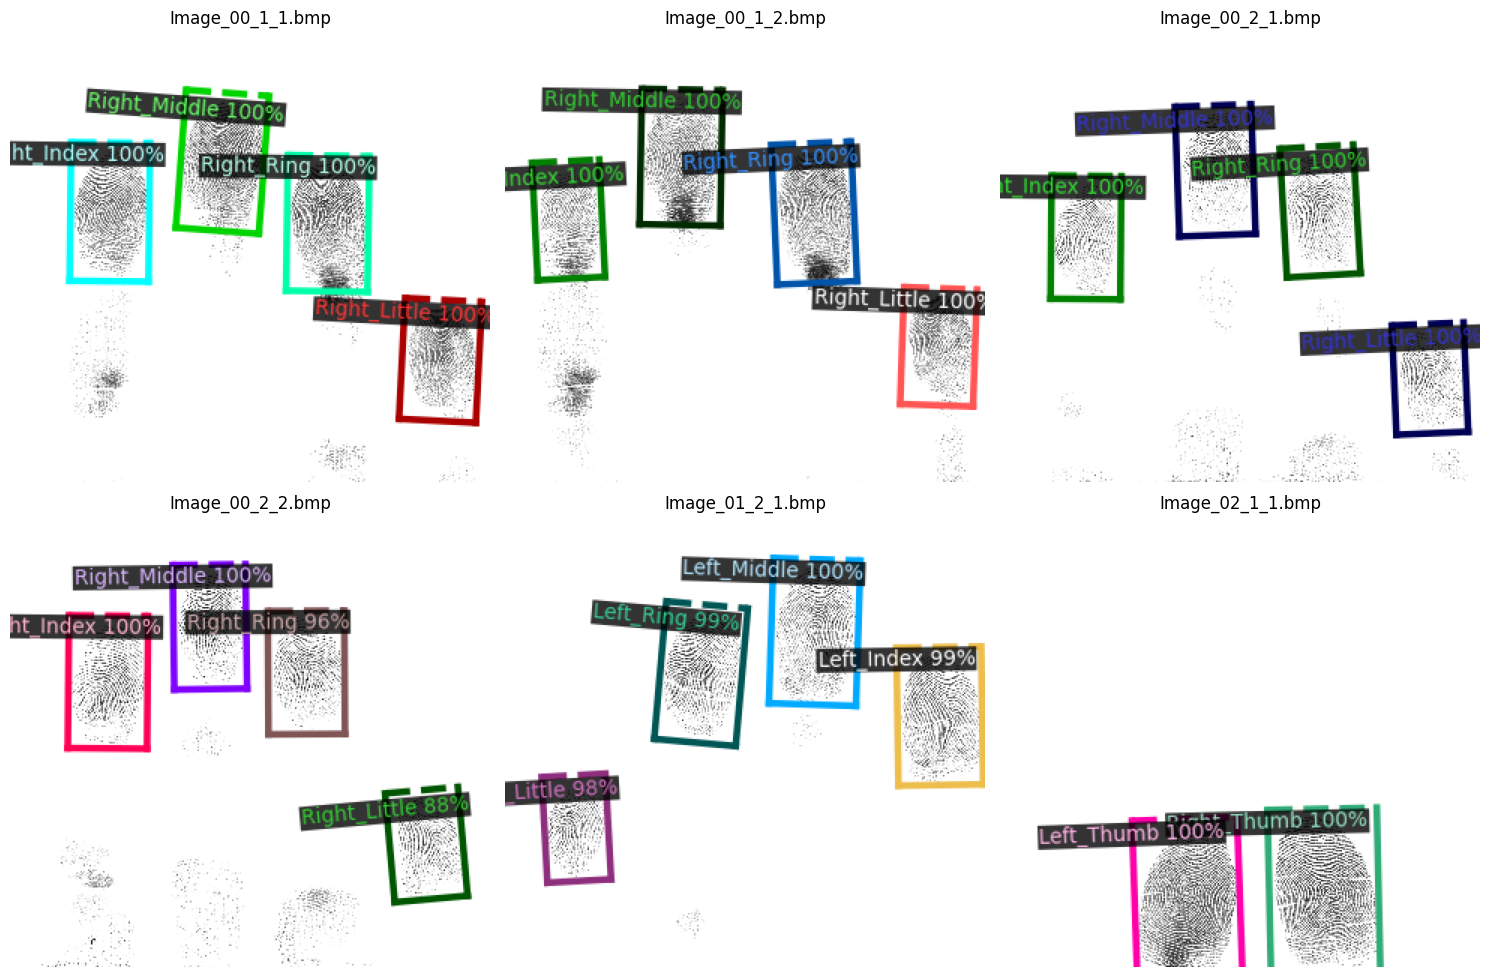

Average inference time (6 images): 2.0271 seconds


In [ ]:
# Take first 6 (sorted for deterministic order)
files = sorted([d["file_name"] for d in test_dict])[:6]

times = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for ax, imname in zip(axes, files):
    im = cv2.imread(imname)

    start_time = time.perf_counter()
    outputs = predictor(im)
    elapsed = time.perf_counter() - start_time
    times.append(elapsed)

    v = myVisualizer(
        im[:, :, ::-1],
        metadata=MetadataCatalog.get("Test"),
        scale=0.2
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(os.path.basename(imname))
    ax.axis("off")

# If fewer than 6 images exist, hide unused axes
for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

avg_time = sum(times) / len(times) if times else float("nan")
print(f"Average inference time ({len(times)} images): {avg_time:.4f} seconds")


In [49]:
N_RUNS = 100

# Limits thread count to 1 to keep results as reproducible as possible
default_num_threads = torch.get_num_threads()
torch.set_num_threads(1)

# Preload images and warmup model
files = sorted([d["file_name"] for d in test_dict])
images = [cv2.imread(f) for f in files]
for i in range(len(images)):
    _ = predictor(images[i])

times = []
for i in range(N_RUNS):
    im = images[i % len(images)]
    start_time = time.perf_counter()
    _ = predictor(im)
    times.append(time.perf_counter() - start_time)

times = np.array(times)

print(f"CPU inference-only benchmark on one thread")
print(f"mean:   {times.mean()*1000:.2f} ms")
print(f"std:    {times.std(ddof=1)*1000:.2f} ms")

torch.set_num_threads(default_num_threads)

CPU inference-only benchmark on one thread
mean:   4618.77 ms
std:    215.66 ms
